# Кластеризация.

[Кластеризация](https://ru.wikipedia.org/wiki/%D0%9A%D0%BB%D0%B0%D1%81%D1%82%D0%B5%D1%80%D0%BD%D1%8B%D0%B9_%D0%B0%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7) - это один из видов задач обучения без учителя. Задача заключается в разбиении всех объектов на группы похожих между собой объектов и сильно отличающихся от всех остальных. Так как строгого понятия похожести объектов как такового нет, то алгоритмов кластеризации много, да и каждый алгоритм имеет много вариантов работы.

![](http://scikit-learn.org/stable/_images/sphx_glr_plot_cluster_comparison_0011.png)

## KMeans

Метод k-means - это один из наиболее популярных методов кластеризации. Основная идея метода заключается в том, что на каждой итерации пересчитывается центр масс (центроид) для каждого кластера, полученного на предыдущем шаге, затем объекты снова разбиваются на кластеры согласно тому, какой из новых центроидов находится ближе.
Более формально, алгоритм принимает на вход выборку $X_1, \dots, X_N$ и параметр $k$, указывающий необходимое число кластеров. Выходом алгоритма является набор из $k$ центроидов $\{\mu_1, \dots, \mu_k\}$, с помощью которых кластеризация осуществляется путём отнесения каждого объекту к ближайшему центроиду. Все точки внутри одного кластера ближе к центроиду этого кластера, чем к центроиду любого другого кластера.
Метод может быть сформулирован как задача оптимизации, а именно, минимизации суммарного квадратичного отклонения точек кластеров от центров этих кластеров по центроидам и кластерам: $$\sum_{i=1}^k \sum_{X_n \in C_i} ||X_n - \mu_i||^2 \rightarrow \min, \text{где $C_i$ - это $i$-ый кластер, $\mu_i$ - это центр масс кластера $C_i$.}$$
Решение такой задачи оптимизации является NP-трудной задачей, однако существует простой итеративный алгоритм, позволяющий найти локальный минимум указанного функционала. Алгоритм представляет собой последовательное чередование двух шагов до сходимости.
Предположим, что как-то (например, случайно) выбраны начальные положения центроидов $\mu_1, \dots, \mu_k$.

1. Этап кластеризации. На данном этапе происходит кластеризация выборки, как было описано выше: каждый объект относится к кластеру ближайшего к нему центроида. Формально, $$C_i = \{X_n : ||X_n - \mu_i|| \leq ||X_n - \mu_j||, \text{ для всех $j \in \{1, \dots, k\}$}\}.$$

2. Этап обновления центроидов. На данном этапе центроиды пересчитываются, как центры масс только что построенных кластеров. Формально, $$\mu_i = \frac{1}{|C_i|}\sum_{X_n \in C_i} X_n.$$

Этот процесс продолжается, пока центроиды и кластеризация продолжают изменяться. Алгоритм гарантированно сходится, однако не гарантируется достижение глобального минимума, а только одного из локальных минимумов. Другим недостатком алгоритма является то, что итоговая кластеризация зависит от выбора исходных центров кластеров. На практике алгоритм запускается несколько раз из различных начальных приближений, а полученные результаты некоторым образом усредняются. Стоит также отметить, что число кластеров необходимо знать заранее. Существуют различные эвристики, позволяющие выбирать в некотором смысле оптимальное число кластеров.

_определение взято из материалов курса [ODS](https://habrahabr.ru/company/ods/)_

### Литература

- [ODS: Обучение без учителя: PCA и кластеризация](https://habrahabr.ru/company/ods/blog/325654/)
- [Интересные алгоритмы кластеризации, часть первая: Affinity propagation](https://habrahabr.ru/post/321216/) и другие статьи цикла
- [Глава 7: кластеризация и визуализация. К. В. Воронцов](http://www.machinelearning.ru/wiki/images/6/6d/Voron-ML-1.pdf)
- [Документация sklearn.clustering](http://scikit-learn.org/stable/modules/clustering.html)
- [K-Means Clustering - The Math of Intelligence. Siraj Raval](https://www.youtube.com/watch?v=9991JlKnFmk) объяснение с программированием KMeans вручную

In [283]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import random 
from tqdm.notebook import tqdm
from skimage.io import imread
import scipy
from scipy.spatial import distance

%matplotlib inline

# Зафиксируем случайность, чтобы у нас получались одинаковые результаты.
np.random.seed(42)

## Рассмотрим как работает алгоритм кластеризации KMeans на синтетическом примере.

Бросим на плоскость случайно точки с разными параметрами случайности, чтобы образовались кластеры.

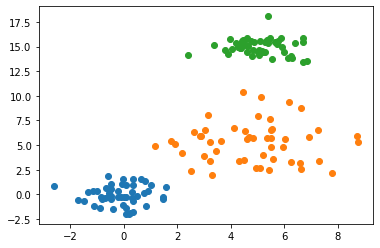

In [284]:
np.random.seed(42)
p1 = np.random.normal(loc=0, scale=1, size=(50,2))
p2 = np.random.normal(loc=5, scale=2, size=(50,2))
p3 = np.random.normal(loc=10, scale=0.8, size=(50,2)) - np.array([5, -5])

X = np.concatenate((p1, p2, p3))

plt.scatter(p1[:,0], p1[:, 1])
plt.scatter(p2[:,0], p2[:, 1])
plt.scatter(p3[:,0], p3[:, 1])

Нарисуем точки на плоскости, но без окрашивания точек. Так будет видеть данные алгоритм. Можем ли мы сами понять где и какие кластеры?

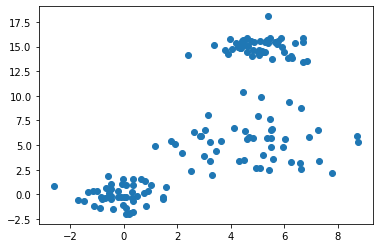

In [285]:
plt.scatter(X[:, 0], X[:, 1])

Рассмотрим пошагово работу алгоритма KMneans на основе обычного евклидова расстояния.  

_Пример из блога ODS: https://habrahabr.ru/company/ods/blog/325654/_

### Задание 1.1 
Напишите функцию, которая рассчитывает расстояния от центров кластеров до каждой точки и возвращает, к какому кластеру принадлежит каждая точка.

In [286]:
def kmeans_predict(x, clusters):
    labels = []
    L = len(clusters)
    
    for cor in x:
        k = [1]*L
        for i in range(L):
            k[i] = scipy.spatial.distance.cdist([clusters[i]],[cor]).reshape(1)
        labels.append(np.argmin(k))
    
    return np.array(labels)

Проверяем что получилось

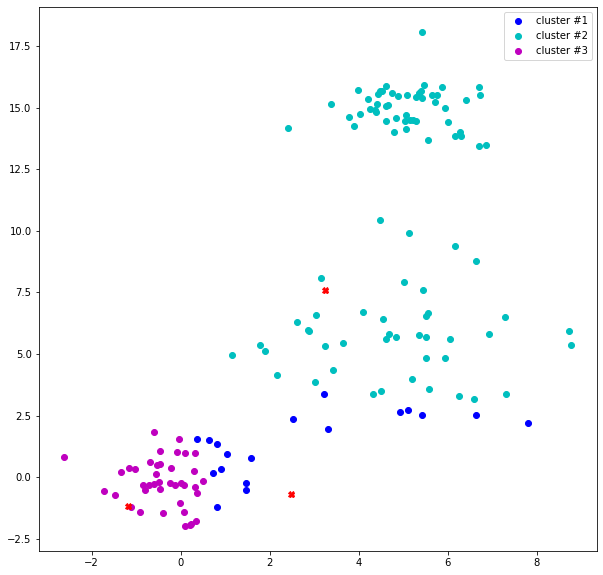

In [287]:
# Генерируем случайные координаты для центров кластеров
np.random.seed(42)

centroids = np.random.normal(loc=0.0, scale=5., size=6)
centroids = centroids.reshape((3, 2)) # итого получаем 3 точки в двумерном пространстве

plt.figure(figsize=(10, 10))
labels = kmeans_predict(X, centroids)

plt.plot(X[labels == 0, 0], X[labels == 0, 1], 'bo', label='cluster #1')
plt.plot(X[labels == 1, 0], X[labels == 1, 1], 'co', label='cluster #2')
plt.plot(X[labels == 2, 0], X[labels == 2, 1], 'mo', label='cluster #3')
plt.plot(centroids[:, 0], centroids[:, 1], 'rX')
plt.legend(loc=0)

###  Задание 1.2 
Напишите код для обновления центров кластеров. Запоминайте центры кластеров $-$ это понадобится потом для визуализации.
Для упрощения каждому облачку данных заранее присвоим кластер.<br>
Положим в каждую новую центроиду геометрический центр её точек.<br>

In [288]:
np.random.seed(42)
centroids = np.random.normal(loc=0.0, scale=1., size=6).reshape((3, 2))

cent_history = [] # История центров кластеров
cent_history.append(np.array(centroids))
STEPS = 5

for i in range(STEPS):
    
    L = len(centroids) # Количество кластеров
    dt = kmeans_predict(X, centroids) # Массив с кластерами
    
    for k in range(L):
        if (len(X[dt == k]) > 0):
            centroids[k] = np.sum(X[dt == k],axis=0)/len(X[dt == k])
        else:
            centroids[k] = np.random.normal(loc=0.0, scale=1., size=2).reshape((1, 2))
            
    cent_history.append(np.array(centroids))


А теперь нарисуем всю эту красоту

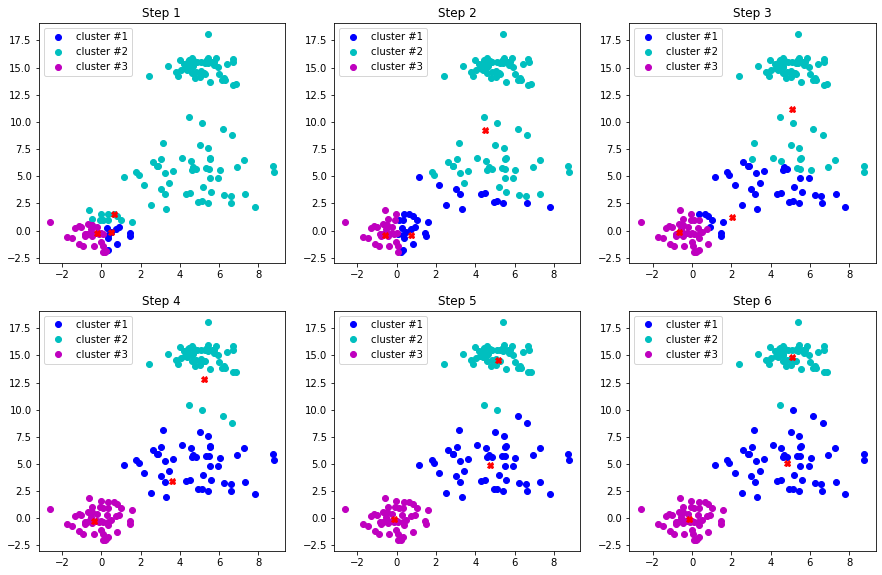

In [289]:
plt.figure(figsize=(15, 15))
for i in range(STEPS + 1):
    labels = kmeans_predict(X, cent_history[i])

    plt.subplot((STEPS + 1) // 2, (STEPS + 1) // 2, i + 1)
    plt.plot(X[labels == 0, 0], X[labels == 0, 1], 'bo', label='cluster #1')
    plt.plot(X[labels == 1, 0], X[labels == 1, 1], 'co', label='cluster #2')
    plt.plot(X[labels == 2, 0], X[labels == 2, 1], 'mo', label='cluster #3')
    plt.plot(cent_history[i][:, 0], cent_history[i][:, 1], 'rX')
    plt.legend(loc=0)
    plt.title('Step {:}'.format(i + 1))

Обратите внимание, последние 3 шага уже не сильно изменили координаты центров кластеров и состав кластеров.

### 1.3 Напишите функцию обучения kMeans, которая возвращает центры кластеров и к какому кластеру принадлежит каждая точка. 

* k - кол-во кластеров
* max_iter - через сколько итераций остановится
* tol - если сумма расстояний между прошлыми центрами кластеров и новыми центрами меньше tol, то остановится
* low и high - это минимально и максимально значение которое могут принимать точки центров кластеров при генерации

In [290]:
def gen_c(low,high,k,x,par):
    
    '''
    Функция генерирует рандомные центры масс до тех пор, пока каждому кластеру не будет соответствовать минимум 'par' точек
    '''
    
    centroids = np.random.uniform(low=low, high=high, size=(k,len(x[0])))
    check = 0
    
    while(check == 0):
            labels = []
            L = len(centroids)
            for cor in x:
                tem = [1]*L
                for w in range(L): tem[w] = distance.euclidean([centroids[w]],[cor])
                labels.append(np.argmin(tem))

            check = 1
            for pp in range(k):
                if(len(x[np.array(labels) == pp]) < par):
                    centroids[pp] = np.random.uniform(low=low, high=high, size=(1,len(x[0])))
                    check = 0
                    break
                    
    return centroids, labels, L


def kmeans_fit_predict(x, k=8, max_iter=100, tol=0.1, low=0.0, high=1.0):
    
    centroids, labels, L = gen_c(low,high,k,x,2) # Генерируем центры масс и считаем классы точек
                        
    for i in range(max_iter):
        
        # Пересчитываем расстояния до центров масс и переопределяем классы точек
        if(i!=0):
            labels = []
            L = len(centroids)
            for cor in x:
                tem = [1]*L
                for w in range(L): tem[w] = distance.euclidean([centroids[w]],[cor])
                labels.append(np.argmin(tem))
        

        class_point = np.array(labels)
        centr_old = centroids + 0
        
        # Обновляем центры масс
        for k in range(L): centroids[k] = np.average((x[class_point == k]),axis=0)
        
        # Считаем Loss
        loss = np.sum(abs(centr_old-centroids))
        print(f"Итерация №{i+1}; loss = {loss}")
        
        if (loss < tol):
            break 

    return centroids, class_point

Проверим работу на точках: воспользуемся kmeans_fit_predict и построим график для результата предсказания кластеров. 

In [291]:
# установим число кластеров k равное трем
# не генерируем центр кластера выше максимального значения из Х - ограничим это используя high
clusters_mnist, labels_mnist = kmeans_fit_predict(X, k=3, low=0.0, high=np.max(X))

Итерация №1; loss = 33.03300487238561
Итерация №2; loss = 8.838376057238019
Итерация №3; loss = 6.7274778926898335
Итерация №4; loss = 2.989064788878789
Итерация №5; loss = 1.010249744199793
Итерация №6; loss = 0.2061121023424594
Итерация №7; loss = 0.0


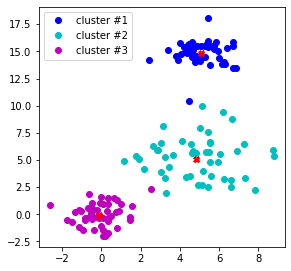

In [292]:
plt.figure(figsize=(15, 15))
plt.subplot((STEPS + 1) // 2, (STEPS + 1) // 2, i + 1)
plt.plot(X[labels_mnist == 0, 0], X[labels_mnist == 0, 1], 'bo', label='cluster #1')
plt.plot(X[labels_mnist == 1, 0], X[labels_mnist == 1, 1], 'co', label='cluster #2')
plt.plot(X[labels_mnist == 2, 0], X[labels_mnist == 2, 1], 'mo', label='cluster #3')
plt.plot(cent_history[i][:, 0], cent_history[i][:, 1], 'rX')
plt.legend(loc=0)

## MNIST

Рассмотрим датасет рукописных цифр MNIST, с которым мы уже работали в задании по KNN.



In [293]:
from sklearn import datasets

X, y = datasets.load_digits(return_X_y=True)

print("Экземпляров: {}\nРазмер изображения: {}x{}".format(X.shape[0], np.sqrt(X.shape[1]), np.sqrt(X.shape[1])))

Экземпляров: 1797
Размер изображения: 8.0x8.0


Подумайте, как можно использовать kmeans для классификации

**Ваш ответ:** 


Натренируйте kMeans используя функцию `kmeans_fit_predict()`, выберите high и low (как в примере с точками). Выберите подходящее число кластеров

In [294]:
clusters_mnist, labels_mnist =  kmeans_fit_predict(X, k = 10, max_iter = 50,tol = 0.01,low=0.0,high = np.max(X))

Итерация №1; loss = 3385.80346280534
Итерация №2; loss = 531.1142209357313
Итерация №3; loss = 250.6407631467249
Итерация №4; loss = 136.31609728400883
Итерация №5; loss = 121.62503431683379
Итерация №6; loss = 94.03349168429952
Итерация №7; loss = 77.63753434449691
Итерация №8; loss = 49.44909101835652
Итерация №9; loss = 31.917211025945353
Итерация №10; loss = 24.019198791724307
Итерация №11; loss = 15.478509979371896
Итерация №12; loss = 11.35915551510562
Итерация №13; loss = 8.11203408870178
Итерация №14; loss = 1.523365303893679
Итерация №15; loss = 3.7633818255400078
Итерация №16; loss = 4.5006302170943435
Итерация №17; loss = 2.8679901536784267
Итерация №18; loss = 1.6916625137056918
Итерация №19; loss = 1.4254649306274931
Итерация №20; loss = 0.0


Проверим. Выведем 10 точек из какого нибудь кластера и посмотрим, что они соотвествуют одной цифре.

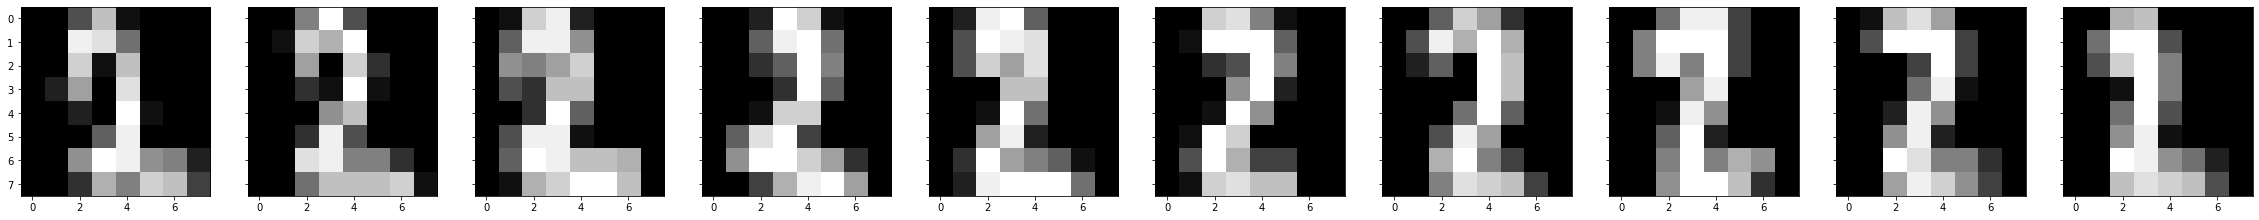

In [295]:
number = 5# Номер кластера
count = 10 # Кол-во примеров
testX = X[labels_mnist == number]

testX[0,:].reshape([8,8])
f, axes = plt.subplots(1, count, sharey=True, figsize=(40,6))
for i in range(count):
    axes[i].imshow(testX[i,:].reshape([8,8]), cmap='gray')

## Центры кластеров фотографий

Можно найти центры кластеров по фотографиям людей.

Возьмем фото 12 разных людей и разобьем их на кластеры. Так можно решать, например, задачу идентификации людей. Можно добавлять новое лицо и, не переобучая kmeans, определять, кто на этой фотографии (к какому кластеру относится картинка).

In [296]:
# загрузим датасет с фотографиями знаменитостей
from sklearn import datasets
lfw_people = datasets.fetch_lfw_people(min_faces_per_person=50)

Ariel Sharon: 77 photos.
Colin Powell: 236 photos.
Donald Rumsfeld: 121 photos.
George W Bush: 530 photos.
Gerhard Schroeder: 109 photos.
Hugo Chavez: 71 photos.
Jacques Chirac: 52 photos.
Jean Chretien: 55 photos.
John Ashcroft: 53 photos.
Junichiro Koizumi: 60 photos.
Serena Williams: 52 photos.
Tony Blair: 144 photos.


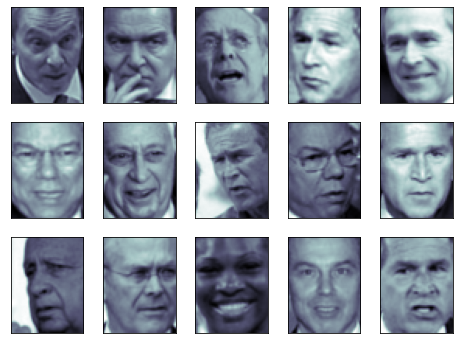

In [297]:
fig = plt.figure(figsize=(8, 6))

for i in range(15):
    ax = fig.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(lfw_people.images[i], cmap='bone')

for i, name in enumerate(lfw_people.target_names):
    print("{}: {} photos.".format(name, (lfw_people.target == i).sum()))

### 3.1 Натренируйте kMeans и нарисуйте центры кластеров как картинки выше.

Итерация №1; loss = 2299322.379114529
Итерация №2; loss = 273222.53139686584
Итерация №3; loss = 137160.93624687195
Итерация №4; loss = 82076.58881950378
Итерация №5; loss = 53034.11400985718
Итерация №6; loss = 46795.001890182495
Итерация №7; loss = 32806.383880615234
Итерация №8; loss = 35303.468925476074
Итерация №9; loss = 29272.097763061523
Итерация №10; loss = 27369.53592300415
Итерация №11; loss = 19716.172039031982
Итерация №12; loss = 21725.849983215332
Итерация №13; loss = 22476.260761260986
Итерация №14; loss = 21968.217323303223
Итерация №15; loss = 18980.399936676025
Итерация №16; loss = 14465.676342010498
Итерация №17; loss = 11466.62251663208
Итерация №18; loss = 7908.924503326416
Итерация №19; loss = 4500.0815505981445
Итерация №20; loss = 3497.3121910095215
Итерация №21; loss = 671.3405685424805
Итерация №22; loss = 0.0


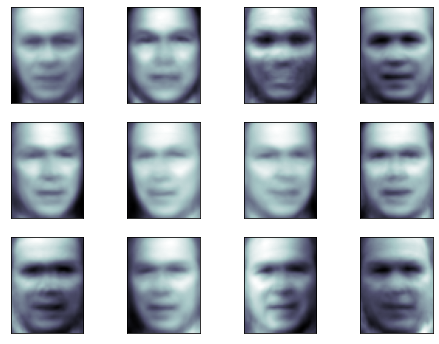

In [298]:
c_m, l_m =  kmeans_fit_predict(lfw_people.data, k = 12, max_iter = 100,tol = 0.0001,low=0.0,high = np.max(lfw_people.data))

fig = plt.figure(figsize=(8, 6))
for i,center in enumerate(c_m):
    ax = fig.add_subplot(3, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(center[:].reshape([62,2914//62]), cmap='bone')

## Визуализация 64-мерного пространства, используя PCA и TSNE

Просто так визуализировать 64-мерный объект не получится, нам нужно уменьшить его размерность до 2, чтобы он укладывался на плоскость.

Существует специальный алгоритм PCA - Метод главных компонент.

![](http://scikit-learn.org/stable/_static/scikit-learn-logo-small.png)

Далее мы будем использовать библиотеку [scikit-learn](http://scikit-learn.org/). По сути это библиотека-набор разных алгоритмов анализа данных, машинного обучения.

Документация по библиотеке всегда доступна:
- по ? в jupyter
- по комбинации shift-tab в jupyter
- на сайте http://scikit-learn.org/stable/documentation.html

Просто так визуализировать 64-мерный объект не получится, нам нужно уменьшить его размерность до 2, чтобы он укладывался на плоскость.

Существует специальный алгоритм PCA -  [Метод главных компонент](https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D0%B3%D0%BB%D0%B0%D0%B2%D0%BD%D1%8B%D1%85_%D0%BA%D0%BE%D0%BC%D0%BF%D0%BE%D0%BD%D0%B5%D0%BD%D1%82).

Нарисуем scatter plot для тренировочной выборки: на графике у нас будут точки, помеченные лейблом - цифрой которую обозначает эта точка в пространстве.

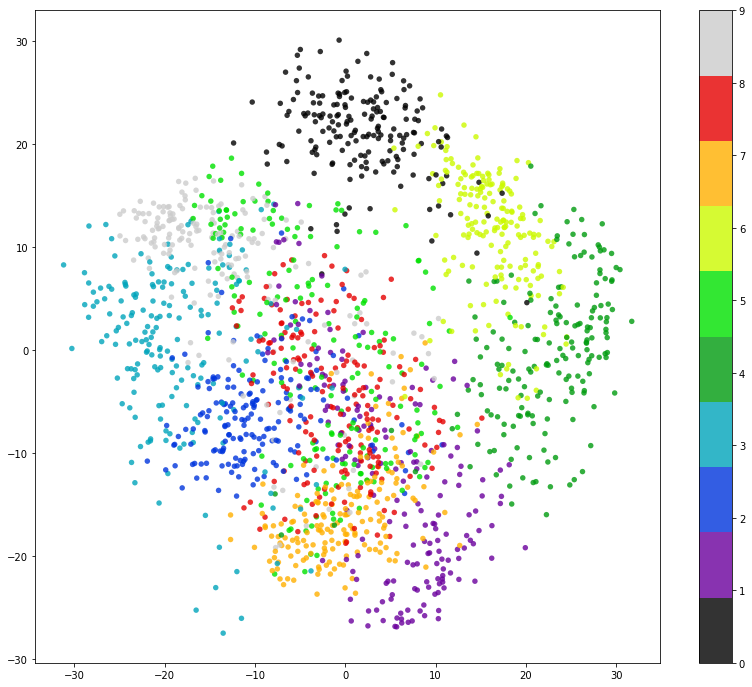

In [299]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=42) # 2 компоненты, значит 2-мерное представление

X_reduced = pca.fit_transform(X)
plt.figure(figsize=(14,12))
plt.scatter(X_reduced[:,0], X_reduced[:,1], c=y, cmap=plt.cm.get_cmap('nipy_spectral', 10),
            edgecolor='none', alpha=0.8, s=30,)
plt.colorbar()

А теперь посмотрим как расставил границы наш алгоритм KMeans. Как видим - хоть цвета и перепутаны, но сами кластеры угадываются.

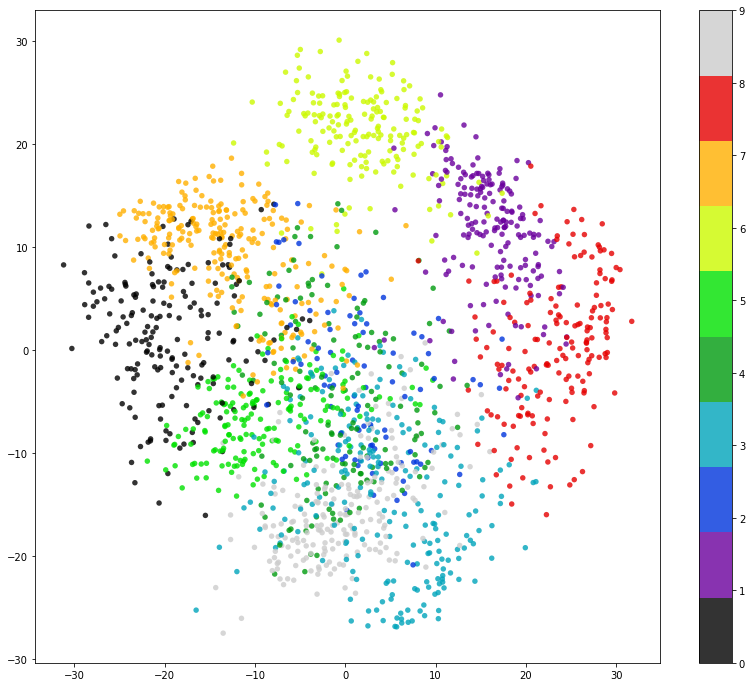

In [300]:
plt.figure(figsize=(14,12))
plt.scatter(X_reduced[:,0], X_reduced[:,1], c=labels_mnist, cmap=plt.cm.get_cmap('nipy_spectral', 10),
            edgecolor='none', alpha=0.8, s=30,)
plt.colorbar()

Центры кластеров представляют из себя нечто среднее, окруженное максимально "похожими" на них элементами. Поэтому мы можем предположить, что на визуализации, центры кластеров будут похожи на цифры.

Центры кластеров можно получить у модели лежат в `clusters_mnist`.

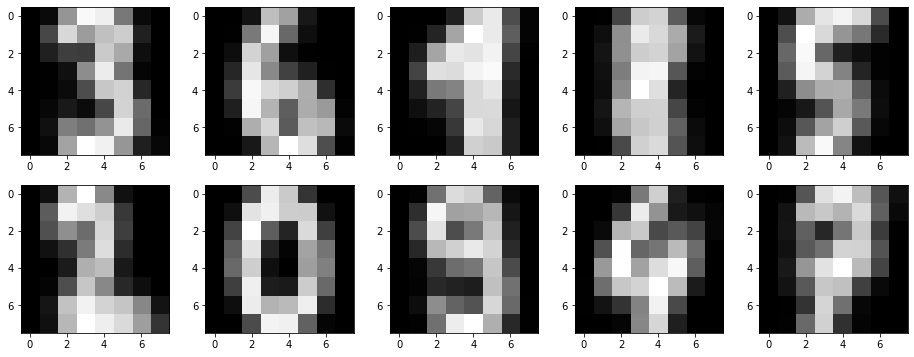

In [301]:
plt.figure(figsize=(16, 6))

for i, center in enumerate(clusters_mnist):
    plt.subplot(2, 5, i + 1)
    plt.imshow(center[:].reshape([8,8]), cmap='gray')

Существуют и другие методы понижения размерности, например t-SNE, но он намного медленнее чем PCA.

Мы пока что не изучаем как именно работают PCA и tSNE, просто восхтимся их способностями.

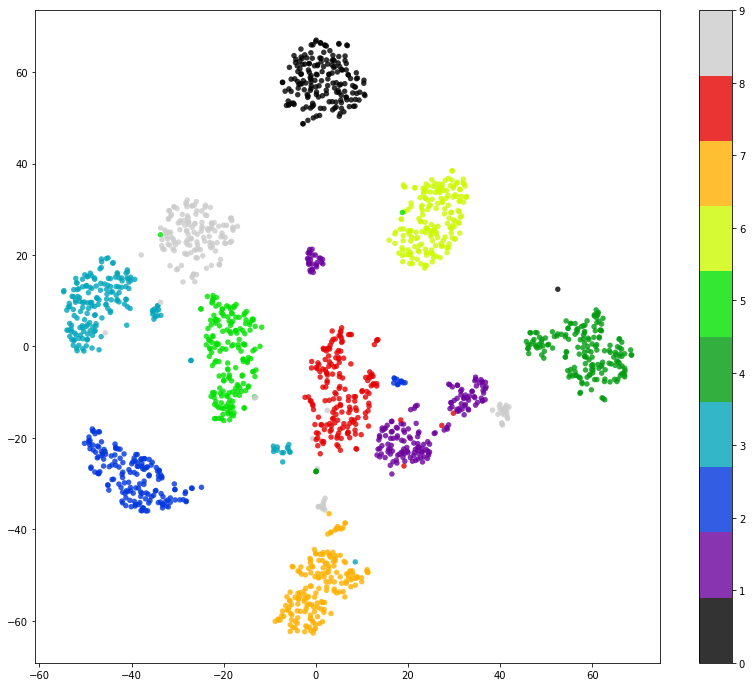

In [302]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init='pca', random_state=42)
X_reduced_t = tsne.fit_transform(X)

plt.figure(figsize=(14,12))
plt.scatter(X_reduced_t[:,0], X_reduced_t[:,1], c=y, cmap=plt.cm.get_cmap('nipy_spectral', 10),
            edgecolor='none', alpha=0.8, s=30,)
plt.colorbar()

Теперь нарисуем тот же scatter-plot, только на основе лейблов из kMeans. Ожидаем что кластеры будут покрашены в нужные цвета.

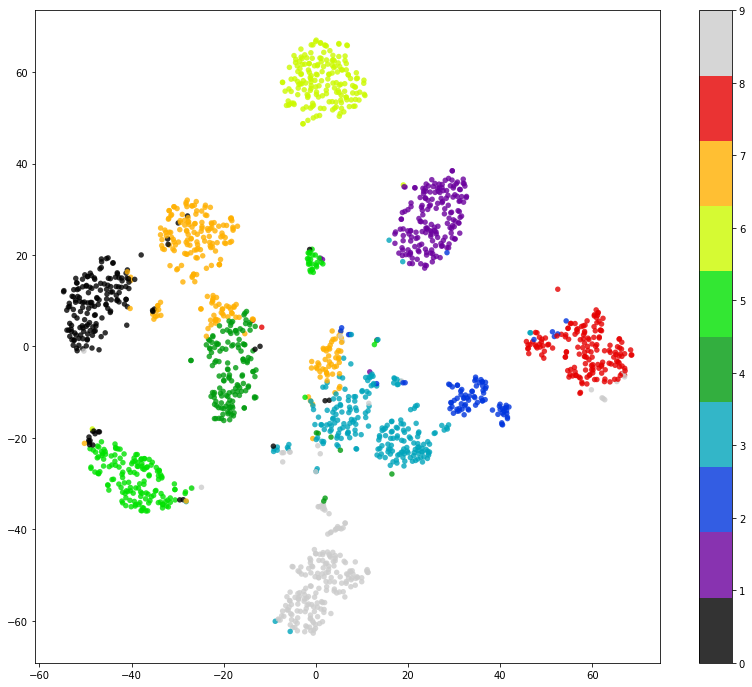

In [303]:
plt.figure(figsize=(14,12))
plt.scatter(X_reduced_t[:,0], X_reduced_t[:,1], c=labels_mnist, cmap=plt.cm.get_cmap('nipy_spectral', 10),
            edgecolor='none', alpha=0.8, s=30,)
plt.colorbar()